# Evaluation 

Run each of the 5 models, using the default hyper-parameter values based off the grid-search, over 10000 simulations.

In [1]:
import random
import numpy as np 
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from math import log10, floor
from scipy.stats import t
import matplotlib.pyplot as plt
from wordle_base_15k import run_simulations as rl_base
from wordle_cluster_15k import run_simulations as rl_cluster
from wordle_cluster_2k import run_simulations as rl_cluster_2
from wordle_greedy_search_15k import run_simulations as greed_search
from wordle_greedy_search_2k import run_simulations as greed_search_2

Running the 10000 simulations per model.

In [3]:
run = False
if run == True:
    results = pd.DataFrame(columns=['time_taken', 'average_guesses', 'win_rate'])

    for i in tqdm(range(5)):
        if i == 0:
            time_taken, average_guesses, win_rate, guesses = rl_base(learning_rate=0.1, exploration_rate=0.8, shrinkage_factor=0.8, num_simulations=10000)
            base_guesses = guesses
            results.loc[0] = [time_taken, average_guesses, win_rate]
        elif i == 1:
            time_taken, average_guesses, win_rate, guesses = rl_cluster(learning_rate=0.1, exploration_rate=0.5, number_of_cluster=6 ,shrinkage_factor=0.9, num_simulations=10000)
            cluster_guesses = guesses
            results.loc[1] = [time_taken, average_guesses, win_rate]
        elif i == 2:
            time_taken, average_guesses, win_rate, guesses = rl_cluster_2(learning_rate=0.001, exploration_rate=0.9, number_of_cluster=9, shrinkage_factor=0.9, num_simulations=10000)
            cluster_2_guesses = guesses
            results.loc[2] = [time_taken, average_guesses, win_rate]
        elif i == 3:
            time_taken, average_guesses, win_rate, guesses = greed_search(num_simulations=10000)
            greedy_search_guesses = guesses
            results.loc[3] = [time_taken, average_guesses, win_rate]
        elif i == 4:
            time_taken, average_guesses, win_rate, guesses = greed_search_2(num_simulations=10000)
            greedy_search_2_guesses = guesses
            results.loc[4] = [time_taken, average_guesses, win_rate]

    results.to_csv('evaluation_results/results.csv')
    np.save('evaluation_results/base_guesses.npy', base_guesses)
    np.save('evaluation_results/cluster_guesses.npy', cluster_guesses)
    np.save('evaluation_results/cluster_2_guesses.npy', cluster_2_guesses)
    np.save('evaluation_results/greedy_search_guesses.npy', greedy_search_guesses)
    np.save('evaluation_results/greedy_search_2_guesses.npy', greedy_search_2_guesses)

Loading the saved results.

In [5]:
results = pd.read_csv('evaluation_results/results.csv')
base_guesses = np.load('evaluation_results/base_guesses.npy')
cluster_guesses = np.load('evaluation_results/cluster_guesses.npy')
cluster_2_guesses = np.load('evaluation_results/cluster_2_guesses.npy')
greedy_search_guesses = np.load('evaluation_results/greedy_search_guesses.npy')
greedy_search_2_guesses = np.load('evaluation_results/greedy_search_2_guesses.npy')

Checking for burn-in period and if the Q-learning reduces the guesses.

Text(0.02, 0.5, 'Number of Guesses required to get goal word')

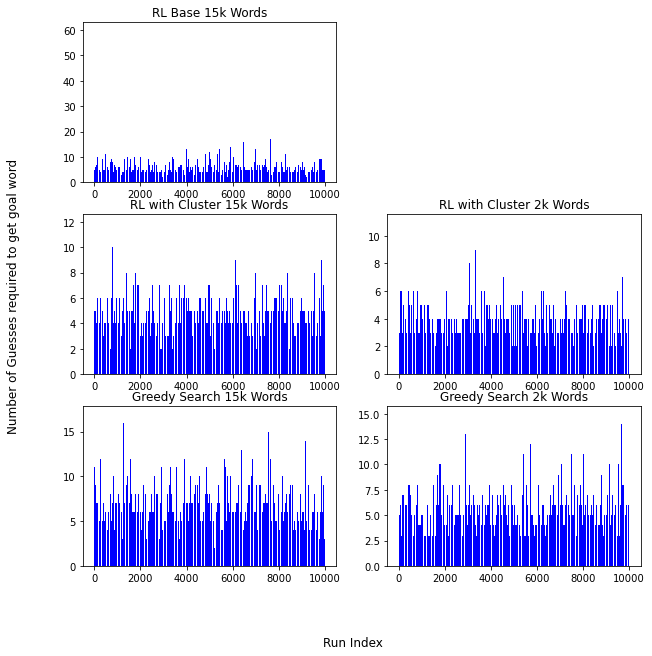

In [4]:
epochs = np.arange(10000)
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
ax[0, 0].bar(epochs, base_guesses, color='blue')
ax[0, 0].set_title('RL Base 15k Words')
ax[1, 0].bar(epochs, cluster_guesses, color='blue')
ax[1, 0].set_title('RL with Cluster 15k Words')
ax[1, 1].bar(epochs, cluster_2_guesses, color='blue')
ax[1, 1].set_title('RL with Cluster 2k Words')
ax[2, 0].bar(epochs, greedy_search_guesses, color='blue')
ax[2, 0].set_title('Greedy Search 15k Words')
ax[2, 1].bar(epochs, greedy_search_2_guesses, color='blue')
ax[2, 1].set_title('Greedy Search 2k Words')
ax[0, 1].set_axis_off()
fig.supxlabel('Run Index')
fig.supylabel('Number of Guesses required to get goal word')

Do the batch-avg calculations with burn-in period of 1000 aka remove first batch for average guesses.

In [14]:
from matplotlib_inline.backend_inline import matplotlib


def batch_calc(guesses:np.ndarray): 
    guesses_mean = []
    for i in range(0, len(guesses), 1000):
        guesses_mean.append(np.mean(guesses[i:i+1000]))
    guesses_mean = np.array(guesses_mean)
    guesses_mean = guesses_mean[1:]
    return guesses_mean

def round_sig(x, sig=3):
    return round(x, sig-int(floor(log10(abs(x))))-1)

def calculate_t_test_CI(values, confidence:int):
    dof = len(values) - 1
    conf = confidence
    t_crit = np.abs(t.ppf((1-confidence)/2,dof))
    mean = np.mean(values)
    variance = np.var(values)
    return (round((mean - t_crit * (variance / np.sqrt(dof))),3), round((mean + t_crit * (variance / np.sqrt(dof))),3))

base_avg_guesses = batch_calc(base_guesses)
cluster_avg_guesses = batch_calc(cluster_guesses)
cluster_2_avg_guesses = batch_calc(cluster_2_guesses)
greedy_search_avg_guesses = batch_calc(greedy_search_guesses)
greedy_search_2_avg_guesses = batch_calc(greedy_search_2_guesses)

sns.lineplot(x=range(len(base_avg_guesses)), y=base_avg_guesses, marker='o', markersize=5, linewidth=1, label='RL base with 15k words')
sns.lineplot(x=range(len(cluster_avg_guesses)), y=cluster_avg_guesses, marker='o', markersize=5, linewidth=1, label='RL with cluster 15k words')
sns.lineplot(x=range(len(cluster_2_avg_guesses)), y=cluster_2_avg_guesses, marker='o', markersize=5, linewidth=1, label='RL with cluster 2k words')
sns.lineplot(x=range(len(greedy_search_avg_guesses)), y=greedy_search_avg_guesses, marker='o', markersize=5, linewidth=1, label='Greedy Search 15k words')
sns.lineplot(x=range(len(greedy_search_2_avg_guesses)), y=greedy_search_2_avg_guesses, marker='o', markersize=5, linewidth=1, label='Greedy Search 2k words')

for i in range(len(base_avg_guesses)):
    plt.text(i, base_avg_guesses[i], str(base_avg_guesses[i]), horizontalalignment='center', verticalalignment='bottom')
    plt.text(i, cluster_avg_guesses[i], str(cluster_avg_guesses[i]), horizontalalignment='center', verticalalignment='bottom')
    plt.text(i, cluster_2_avg_guesses[i], str(cluster_2_avg_guesses[i]), horizontalalignment='center', verticalalignment='bottom')
    plt.text(i, greedy_search_avg_guesses[i], str(greedy_search_avg_guesses[i]), horizontalalignment='center', verticalalignment='bottom')
    plt.text(i, greedy_search_2_avg_guesses[i], str(greedy_search_2_avg_guesses[i]), horizontalalignment='center', verticalalignment='bottom')
    
plt.title("Average guesses per 1000 simulations")
plt.xlabel("Batch number (1000 simulations per batch)")
plt.ylabel("Average guesses")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

base_avg_guesses_mean = round_sig(np.mean(base_avg_guesses),3)
cluster_avg_guesses_mean = round_sig(np.mean(cluster_avg_guesses),3)
cluster_2_avg_guesses_mean = round_sig(np.mean(cluster_2_avg_guesses),3)
greedy_search_avg_guesses_mean = round_sig(np.mean(greedy_search_avg_guesses),3)
greedy_search_2_avg_guesses_mean = round_sig(np.mean(greedy_search_2_avg_guesses),3)

base_avg_guesses_variance = round_sig(np.var(base_avg_guesses),3)
cluster_avg_guesses_variance = round_sig(np.var(cluster_avg_guesses),3)
cluster_2_avg_guesses_variance = round_sig(np.var(cluster_2_avg_guesses),3)
greedy_search_avg_guesses_variance = round_sig(np.var(greedy_search_avg_guesses),3)
greedy_search_2_avg_guesses_variance = round_sig(np.var(greedy_search_2_avg_guesses),3)

base_avg_guesses_CI = calculate_t_test_CI(base_avg_guesses, 0.95)
cluster_avg_guesses_CI = calculate_t_test_CI(cluster_avg_guesses, 0.95)
cluster_2_avg_guesses_CI = calculate_t_test_CI(cluster_2_avg_guesses, 0.95)
greedy_search_avg_guesses_CI = calculate_t_test_CI(greedy_search_avg_guesses, 0.95)
greedy_search_2_avg_guesses_CI = calculate_t_test_CI(greedy_search_2_avg_guesses, 0.95)

print(f'Steady state average guesses for RL base with 15k words is {base_avg_guesses_mean}, its variance is {base_avg_guesses_variance} and 95% confidence interval of the average guess is {base_avg_guesses_CI}.')
print(f'Steady state average guesses for RL with clustering & 15k words is {cluster_avg_guesses_mean}, its variance is {cluster_avg_guesses_variance} and 95% confidence interval of the average guess is {cluster_avg_guesses_CI}.')
print(f'Steady state average guesses for RL with clustering & 2k words is {cluster_2_avg_guesses_mean}, its variance is {cluster_2_avg_guesses_variance} and 95% confidence interval of the average guess is {cluster_2_avg_guesses_CI}.')
print(f'Steady state average guesses for Greedy search with 15k words is {greedy_search_avg_guesses_mean}, its variance is {greedy_search_avg_guesses_variance} and 95% confidence interval of the average guess is {greedy_search_avg_guesses_CI}.')
print(f'Steady state average guesses for Greedy search with 2k words is {greedy_search_2_avg_guesses_mean}, its variance is {greedy_search_2_avg_guesses_variance} and 95% confidence interval of the average guess is {greedy_search_2_avg_guesses_CI}.')

Steady state average guesses for RL base with 15k words is 6.22, its variance is 0.00918 and 95% confidence interval of the average guess is (6.213, 6.228).
Steady state average guesses for RL with clustering & 15k words is 4.91, its variance is 0.00208 and 95% confidence interval of the average guess is (4.906, 4.91).
Steady state average guesses for RL with clustering & 2k words is 4.01, its variance is 0.00136 and 95% confidence interval of the average guess is (4.008, 4.01).
Steady state average guesses for Greedy search with 15k words is 7.02, its variance is 0.00475 and 95% confidence interval of the average guess is (7.019, 7.027).
Steady state average guesses for Greedy search with 2k words is 5.47, its variance is 0.003 and 95% confidence interval of the average guess is (5.471, 5.476).


Do the batch-avg calculations with burn-in period of 1000 aka remove first batch for average win rate.

In [23]:
def calculate_win_rate(batch_len:int, guesses):
    win_rate = (batch_len-np.sum(guesses>6))/batch_len*100
    return win_rate

def batch_calc(guesses:np.ndarray): 
    win_rate = []
    for i in range(0, len(guesses), 1000):
        win_rate.append(calculate_win_rate(1000,guesses[i:i+1000]))
    win_rate = np.array(win_rate)
    win_rate = win_rate[1:]
    return win_rate

def round_sig(x, sig=3):
    return round(x, sig-int(floor(log10(abs(x))))-1)

def calculate_t_test_CI(values, confidence:int):
    dof = len(values) - 1
    conf = confidence
    t_crit = np.abs(t.ppf((1-confidence)/2,dof))
    mean = np.mean(values)
    variance = np.var(values)
    return (round((mean - t_crit * (variance / np.sqrt(dof))),1), round((mean + t_crit * (variance / np.sqrt(dof))),1))

base_avg_win_rates = batch_calc(base_guesses)
cluster_avg_win_rates = batch_calc(cluster_guesses)
cluster_2_avg_win_rates = batch_calc(cluster_2_guesses)
greedy_search_avg_win_rates = batch_calc(greedy_search_guesses)
greedy_search_2_avg_win_rates = batch_calc(greedy_search_2_guesses)

sns.lineplot(x=range(len(base_avg_win_rates)), y=base_avg_win_rates, marker='o', markersize=5, linewidth=1, label='RL base with 15k words')
sns.lineplot(x=range(len(cluster_avg_win_rates)), y=cluster_avg_win_rates, marker='o', markersize=5, linewidth=1, label='RL with clustering & 15k words')
sns.lineplot(x=range(len(cluster_2_avg_win_rates)), y=cluster_2_avg_win_rates, marker='o', markersize=5, linewidth=1, label='RL with clustering & 2k words')
sns.lineplot(x=range(len(greedy_search_avg_win_rates)), y=greedy_search_avg_win_rates, marker='o', markersize=5, linewidth=1, label='Greedy search with 15k words')
sns.lineplot(x=range(len(greedy_search_2_avg_win_rates)), y=greedy_search_2_avg_win_rates, marker='o', markersize=5, linewidth=1, label='Greedy search with 2k words')

for i in range(len(base_avg_win_rates)):
    plt.text(i, base_avg_win_rates[i], str(round(base_avg_win_rates[i],3)), horizontalalignment='center', verticalalignment='bottom')
    plt.text(i, cluster_avg_win_rates[i], str(round(cluster_avg_win_rates[i],3)), horizontalalignment='center', verticalalignment='bottom')
    plt.text(i, cluster_2_avg_win_rates[i], str(round(cluster_2_avg_win_rates[i],3)), horizontalalignment='center', verticalalignment='bottom')
    plt.text(i, greedy_search_avg_win_rates[i], str(round(greedy_search_avg_win_rates[i],3)), horizontalalignment='center', verticalalignment='bottom')
    plt.text(i, greedy_search_2_avg_win_rates[i], str(round(greedy_search_2_avg_win_rates[i],3)), horizontalalignment='center', verticalalignment='bottom')
    
plt.title("Average win-rate per 1000 simulations")
plt.xlabel("Batch number (1000 simulations per batch)")
plt.ylabel("Average win-rate")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

base_avg_win_rates_mean = round_sig(np.mean(base_avg_win_rates),3)
cluster_avg_win_rates_mean = round_sig(np.mean(cluster_avg_win_rates),3)
cluster_2_avg_win_rates_mean = round_sig(np.mean(cluster_2_avg_win_rates),3)
greedy_search_avg_win_rates_mean = round_sig(np.mean(greedy_search_avg_win_rates),3)
greedy_search_2_avg_win_rates_mean = round_sig(np.mean(greedy_search_2_avg_win_rates),3)

base_avg_win_rates_variance = round_sig(np.var(base_avg_win_rates),3)
cluster_avg_win_rates_variance = round_sig(np.var(cluster_avg_win_rates),3)
cluster_2_avg_win_rates_variance = round_sig(np.var(cluster_2_avg_win_rates),3)
greedy_search_avg_win_rates_variance = round_sig(np.var(greedy_search_avg_win_rates),3)
greedy_search_2_avg_win_rates_variance = round_sig(np.var(greedy_search_2_avg_win_rates),3)

base_avg_win_rates_CI = calculate_t_test_CI(base_avg_win_rates, 0.95)
cluster_avg_win_rates_CI = calculate_t_test_CI(cluster_avg_win_rates, 0.95)
cluster_2_avg_win_rates_CI = calculate_t_test_CI(cluster_2_avg_win_rates, 0.95)
greedy_search_avg_win_rates_CI = calculate_t_test_CI(greedy_search_avg_win_rates, 0.95)
greedy_search_2_avg_win_rates_CI = calculate_t_test_CI(greedy_search_2_avg_win_rates, 0.95)

print(f'Steady state average guesses for RL base with 15k words is {base_avg_win_rates_mean}, its variance is {base_avg_win_rates_variance} and 95% confidence interval of the average guess is {base_avg_win_rates_CI}.')
print(f'Steady state average guesses for RL with clustering & 15k words is {cluster_avg_win_rates_mean}, its variance is {cluster_avg_win_rates_variance} and 95% confidence interval of the average guess is {cluster_avg_win_rates_CI}.')
print(f'Steady state average guesses for RL with clustering & 2k words is {cluster_2_avg_win_rates_mean}, its variance is {cluster_2_avg_win_rates_variance} and 95% confidence interval of the average guess is {cluster_2_avg_win_rates_CI}.')
print(f'Steady state average guesses for Greedy search with 15k words is {greedy_search_avg_win_rates_mean}, its variance is {greedy_search_avg_win_rates_variance} and 95% confidence interval of the average guess is {greedy_search_avg_win_rates_CI}.')
print(f'Steady state average guesses for Greedy search with 2k words is {greedy_search_2_avg_win_rates_mean}, its variance is {greedy_search_2_avg_win_rates_variance} and 95% confidence interval of the average guess is {greedy_search_2_avg_win_rates_CI}.')

Steady state average guesses for RL base with 15k words is 65.4, its variance is 1.3 and 95% confidence interval of the average guess is (64.4, 66.5).
Steady state average guesses for RL with clustering & 15k words is 87.1, its variance is 0.839 and 95% confidence interval of the average guess is (86.4, 87.8).
Steady state average guesses for RL with clustering & 2k words is 97.5, its variance is 0.187 and 95% confidence interval of the average guess is (97.4, 97.7).
Steady state average guesses for Greedy search with 15k words is 45.4, its variance is 1.52 and 95% confidence interval of the average guess is (44.1, 46.6).
Steady state average guesses for Greedy search with 2k words is 73.7, its variance is 0.849 and 95% confidence interval of the average guess is (73.0, 74.4).


In [7]:
results

,Unnamed: 0,time_taken,average_guesses,win_rate
0,0,1225.686158,6.2231,65.37
1,1,1359.996702,4.9031,87.25
2,2,92.301707,4.0160,97.48
3,3,512.829151,7.0251,45.26
4,4,73.500564,5.4677,73.91


Imbalanced training.

In [22]:
goal_words = []
with open('goal_words.txt', 'r') as file:
    for word in file:
        goal_words.append(word.strip('\n').upper())

words = {}
for i in range(10000):
    word = goal_words[int(np.random.uniform(0,2308))]
    if word in words:
        words[word] += 1
    else:
        words[word] = 1

df = pd.DataFrame(words.items(), columns=['word', 'count'])
df.sort_values(by='count', ascending=False, inplace=True)
df = df['count'].value_counts()

# df.plot(kind='bar')
# plt.title("Distribution of goal words used across 10000 runs")
# plt.xlabel("Number of times used as goal words")
# plt.ylabel("Count of goal words")
df

4     458
3     400
5     358
2     301
6     260
7     184
1     142
8     103
9      37
10     24
11      7
12      5
13      4
Name: count, dtype: int64

In [24]:
# define the inverse function of an uniform CDF
def inverse_uniform_cdf(p, a, b):
    return a + (b - a) * p
    
def inverse_transform(n):
    uniform_draws = np.random.uniform(0, 1, n)
    samples = inverse_uniform_cdf(uniform_draws, 0, 2308)
    return np.round(samples).astype(int)

words = {}
for i in inverse_transform(10000):
    word = goal_words[i]
    if word in words:
        words[word] += 1
    else:
        words[word] = 1

df = pd.DataFrame(words.items(), columns=['word', 'count'])
df.sort_values(by='count', ascending=False, inplace=True)
df = df['count'].value_counts()
df

4     427
3     412
5     370
2     290
6     276
7     177
1     142
8      98
9      48
10     21
11      8
12      4
14      1
13      1
Name: count, dtype: int64